#"Sistem Rekomendasi Film Sederhana dengan Metode Content-Based Filtering Menggunakan Cosine Similarity"

##Pengenalan Dataset

Dataset ini digunakan untuk membangun sistem rekomendasi film sederhana berbasis *Content-Based Filtering* dengan pendekatan *Cosine Similarity*. Data ini mencakup informasi rating pengguna terhadap berbagai film, serta metadata dari setiap film.

Dataset ini sangat cocok untuk eksplorasi data, pembangunan model rekomendasi berbasis pembelajaran mesin, serta pemahaman pola preferensi pengguna terhadap berbagai genre film.

**Sumber Data**: Data ini umumnya berasal dari platform [kaggle](https://www.kaggle.com/datasets/nicoletacilibiu/movies-and-ratings-for-recommendation-system), yang menyediakan dataset rating film untuk tujuan penelitian dan pengembangan.

### Variabel-Variabel pada Dataset

**📁 `movies.csv` (Berisi data metadata film sebanyak 9742)**

* **`movieId`** (`int64`): ID unik untuk setiap film. Digunakan sebagai penghubung dengan data rating.
* **`title`** (`object`): Judul lengkap dari film, seringkali dilengkapi dengan tahun rilis.
* **`genres`** (`object`): Daftar genre dari film, dipisahkan dengan tanda pipa (`|`) (misalnya: `Action|Adventure|Drama`).

**📁 `ratings.csv` (Berisi data interaksi pengguna dan rating sebanyak 100836)**

* **`userId`** (`int64`): ID anonim dari pengguna.
* **`movieId`** (`int64`): ID film yang dirating oleh pengguna. Berfungsi sebagai *foreign key* untuk menghubungkan ke `movieId` di `movies.csv`.
* **`rating`** (`float64`): Rating yang diberikan pengguna terhadap film.
* **`timestamp`** (`int64`): Waktu ketika rating diberikan.
---

Pengenalan ini memberikan gambaran yang jelas tentang dataset yang akan kita gunakan, variabel-variabel yang ada, dan relevansinya untuk proyek sistem rekomendasi kita. Selanjutnya, kita bisa mulai melakukan *Exploratory Data Analysis* (EDA).

##Import Library



In [1]:
import pandas as pd # Untuk manipulasi dan analisis data
import numpy as np # Untuk komputasi numerik
import matplotlib.pyplot as plt # Untuk visualisasi data
import seaborn as sns # Untuk visualisasi data statistik
from sklearn.feature_extraction.text import TfidfVectorizer # Untuk mengubah teks menjadi representasi TF-IDF
from sklearn.metrics.pairwise import cosine_similarity # Untuk menghitung kemiripan kosinus
from sklearn.metrics import precision_score, recall_score, confusion_matrix # Untuk evaluasi model
from sklearn.preprocessing import MultiLabelBinarizer,MinMaxScaler, OneHotEncoder # Untuk preprocessing data
from scipy.sparse import csr_matrix # Untuk membuat matriks sparse
from sklearn.neighbors import NearestNeighbors # Untuk menemukan tetangga terdekat
import warnings # Untuk mengelola peringatan
import re # Untuk operasi regular expression

warnings.filterwarnings('ignore') # Mengabaikan semua pesan peringatan

##Load Data

In [2]:
# Load dataset movies
movies_df = pd.read_csv("/content/drive/MyDrive/movies.csv")
movies_df.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# Load dataset ratings
ratings_df = pd.read_csv("/content/drive/MyDrive/ratings.csv")
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


##Exploratory Data Analysis (EDA)

In [4]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


movies_df  berisi 9,742 entri film dengan tiga kolom utama: `movieId` (identifikasi unik), `title` (judul film), dan `genres` (daftar genre), di mana semua kolom memiliki data lengkap tanpa nilai yang hilang. Tipe data kolom sudah sesuai, dengan `movieId` sebagai integer dan `title` serta `genres` sebagai objek (string).

In [5]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


DataFrame ini berisi 100,836 entri rating dengan empat kolom: `userId`, `movieId`, `rating`, dan `timestamp`. Semua kolom memiliki data lengkap tanpa nilai yang hilang, dengan tipe data yang sesuai untuk analisis, yaitu integer untuk ID dan timestamp, serta float untuk rating.

In [6]:
movies_df.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000




Analisis statistik deskriptif pada kolom `movieId` dari dataset `movies_df` memberikan gambaran tentang identifikasi film:

* **Jumlah Film (Count)**: Terdapat total 9,742 film unik dalam dataset ini.
* **Rentang ID Film**: ID film berkisar dari **minimum** 1 hingga **maksimum** 193,609. Ini menunjukkan cakupan luas ID yang digunakan untuk mengidentifikasi film-film dalam dataset.
* **Distribusi ID Film**: Nilai rata-rata sekitar 42,200 dengan standar deviasi yang besar (52,160), serta kuartil yang tersebar, mengindikasikan bahwa ID film tidak selalu berurutan atau padat, tetapi bisa tersebar luas, yang umum terjadi pada sistem ID unik.

Secara keseluruhan, statistik ini menegaskan jumlah film yang akan diproses oleh sistem rekomendasi kita.


In [7]:
ratings_df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


Analisis statistik deskriptif pada dataset `ratings.csv` memberikan gambaran umum tentang distribusi dan karakteristik data interaksi pengguna:

* **Jumlah Data (Count)**: Terdapat 100,836 entri rating.
* **`userId`**: Mengandung 610 pengguna unik (dari `min` 1 hingga `max` 610), yang menunjukkan jumlah pengguna yang berinteraksi dalam dataset ini.
* **`movieId`**: Merujuk pada 9724 film unik yang telah dirating (dari `min` 1 hingga `max` 193609), menandakan cakupan film dalam interaksi pengguna.
* **`rating`**:
    * **Rata-rata (mean)** rating adalah sekitar 3.50, dengan standar deviasi (std) 1.04, menunjukkan variasi yang cukup.
    * Rating berkisar dari **minimum** 0.5 hingga **maksimum** 5.0.
    * **Kuartil** menunjukkan bahwa 25% rating berada di bawah 3.0, 50% di bawah 3.5 (median), dan 75% di bawah 4.0. Hal ini mengindikasikan bahwa mayoritas rating cenderung berada pada skala menengah hingga tinggi.
* **`timestamp`**: Menunjukkan rentang waktu rating diberikan (dari 828 juta hingga 1.5 miliar dalam format Unix epoch), meskipun kolom ini tidak relevan langsung untuk model *content-based filtering* kita.

Secara keseluruhan, statistik ini memperkuat pemahaman kita tentang skala data, jumlah pengguna dan film, serta kecenderungan umum rating yang diberikan oleh pengguna.



In [8]:
print("Jumlah missing value pada setiap kolom di movies_df:")
print(movies_df.isnull().sum())

print("\nJumlah missing value pada setiap kolom di ratings_df:")
print(ratings_df.isnull().sum())

Jumlah missing value pada setiap kolom di movies_df:
movieId    0
title      0
genres     0
dtype: int64

Jumlah missing value pada setiap kolom di ratings_df:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


Tidak ada missing value di movies_df dan ratings_df, menunjukkan bahwa data sudah bersih

In [9]:
print("Jumlah data terduplikat di movies_df")
print(movies_df.duplicated().sum())

print("\nJumlah data terduplikat di ratings_df")
print(ratings_df.duplicated().sum())

Jumlah data terduplikat di movies_df
0

Jumlah data terduplikat di ratings_df
0


Tidak ada data terduplikat di movies_df dan ratings_df, menunjukkan bahwa data sudah bersih


--- Top 10 Genres ---
Drama        4361
Comedy       3756
Thriller     1894
Action       1828
Romance      1596
Adventure    1263
Crime        1199
Sci-Fi        980
Horror        978
Fantasy       779
Name: count, dtype: int64


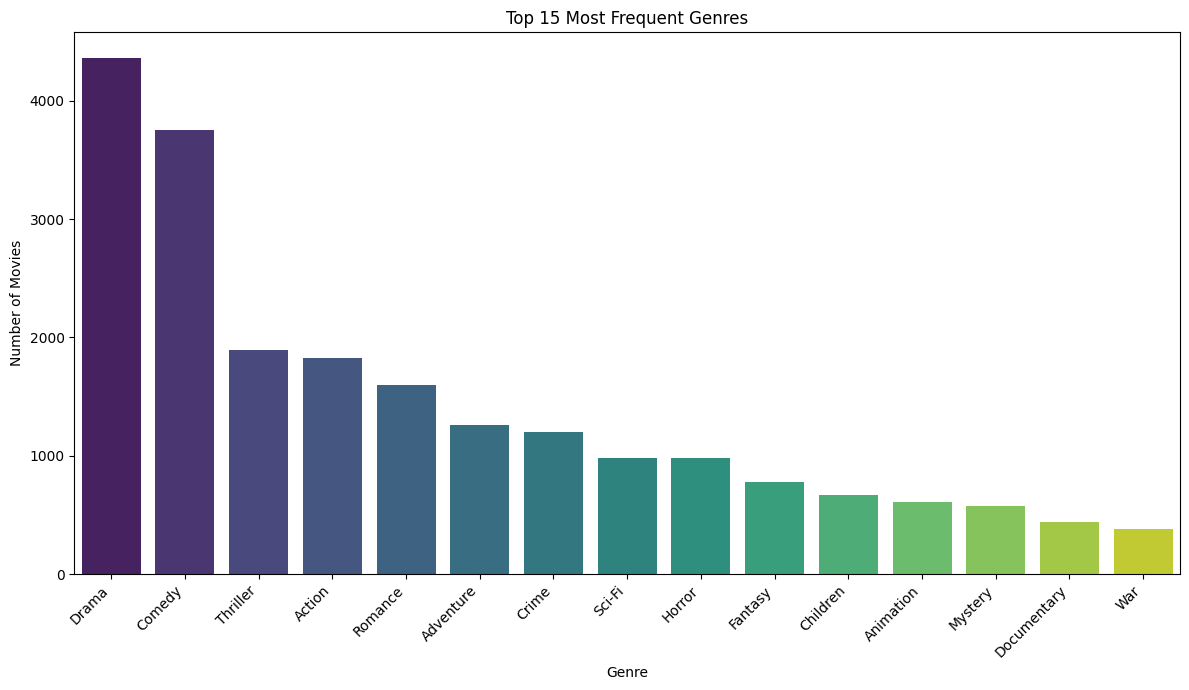

In [13]:
genres_split = movies_df['genres'].str.split('|', expand=True).stack()
genre_counts = genres_split.value_counts()

print("\n--- Top 10 Genres ---")
print(genre_counts.head(10))
plt.figure(figsize=(12, 7))
sns.barplot(x=genre_counts.head(15).index, y=genre_counts.head(15).values, palette='viridis')
plt.title('Top 15 Most Frequent Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Analisis Genre Film
Dari hasil perhitungan dan visualisasi Top 15 Most Frequent Genres:

- Drama adalah genre paling dominan, muncul dalam 4361 film.
- Diikuti oleh Comedy (3756 film), Thriller (1894 film), Action (1828 film), dan Romance (1596 film).
- Ini menunjukkan bahwa dataset kita kaya akan film-film dari genre populer, yang akan membantu dalam membuat rekomendasi yang beragam.

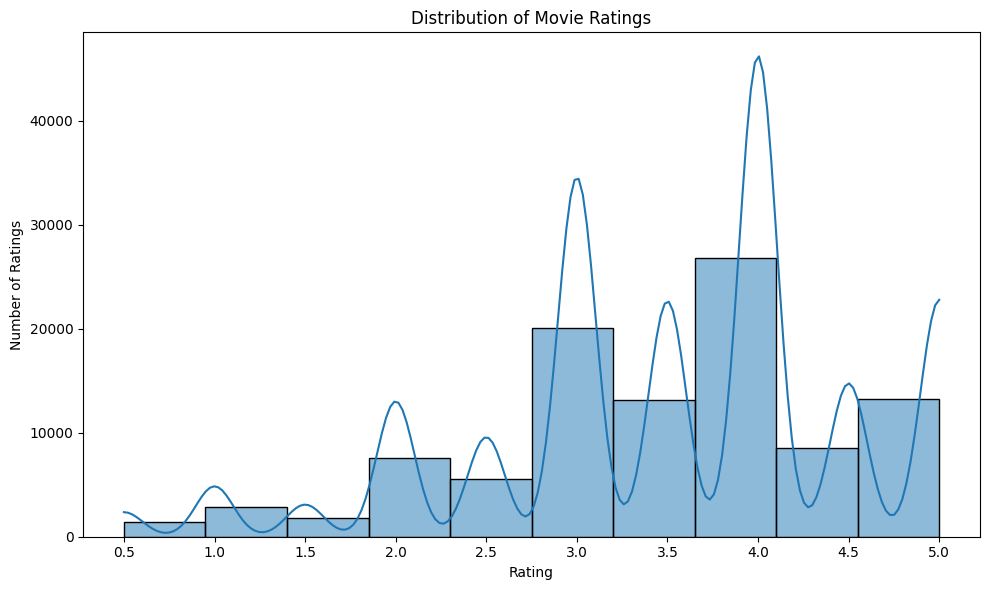

In [14]:
# --- EDA Step 2: Analyze ratings ---|

plt.figure(figsize=(10, 6))
sns.histplot(ratings_df['rating'], bins=10, kde=True, palette='coolwarm')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.xticks(np.arange(0.5, 5.5, 0.5)) # Set x-ticks to match rating scale
plt.tight_layout()
plt.show()



* Distribusi rating menunjukkan kecenderungan pengguna untuk memberikan rating yang cukup tinggi, dengan puncak tertinggi berada pada rating 4.0.
* Mayoritas rating berkisar antara 3.0 hingga 4.5, mengindikasikan bahwa sebagian besar film dinilai cukup baik oleh pengguna.
* Rating terendah (0.5) dan tertinggi (5.0) menunjukkan keseluruhan skala rating yang digunakan, namun frekuensi rating di ujung ekstrim lebih jarang dibandingkan rating di tengah hingga tinggi.

In [11]:
# --- Jumlah Unik Pengguna dan Film ---
num_unique_users = ratings_df['userId'].nunique()
num_unique_movies_rated = ratings_df['movieId'].nunique()
num_total_movies = movies_df['movieId'].nunique()

print(f"\nJumlah Unique Users: {num_unique_users}")
print(f"Jumlah Unique Movies Rated: {num_unique_movies_rated}")
print(f"Jumlah Total Movies di movies_df: {num_total_movies}")


Jumlah Unique Users: 610
Jumlah Unique Movies Rated: 9724
Jumlah Total Movies di movies_df: 9742


Jumlah Pengguna dan Film Unik:
- Jumlah Pengguna Unik: Terdapat 610 pengguna unik yang memberikan rating.
- Jumlah Film Unik yang Dirating: Terdapat 9724 film unik yang telah dirating oleh pengguna.
- Total Film di movies_df: Terdapat 9742 film total di dataset movies_df. Ini berarti sebagian besar film di dataset movies_df sudah memiliki setidaknya satu rating.

##Data Preparation

In [15]:
# --- Data Preparation ---

# Mengisi nilai "(no genres listed)" dengan string kosong
movies_df['genres'] = movies_df['genres'].replace('(no genres listed)', '')

# Mengubah format genres dari 'Action|Adventure' menjadi 'Action Adventure'
# Ini diperlukan agar TfidfVectorizer dapat memprosesnya dengan benar
movies_df['clean_genres'] = movies_df['genres'].apply(lambda x: x.replace('|', ' '))

print("--- movies_df setelah Data Preparation (kolom clean_genres) ---")
print(movies_df.head())

print("\n--- Info movies_df setelah Data Preparation ---")
print(movies_df.info())

# Memeriksa apakah ada film tanpa genre setelah preprocessing
no_genre_movies = movies_df[movies_df['clean_genres'] == '']
print(f"\nJumlah film tanpa genre terdaftar setelah preprocessing: {len(no_genre_movies)}")

--- movies_df setelah Data Preparation (kolom clean_genres) ---
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  \
0  Adventure|Animation|Children|Comedy|Fantasy   
1                   Adventure|Children|Fantasy   
2                               Comedy|Romance   
3                         Comedy|Drama|Romance   
4                                       Comedy   

                                  clean_genres  
0  Adventure Animation Children Comedy Fantasy  
1                   Adventure Children Fantasy  
2                               Comedy Romance  
3                         Comedy Drama Romance  
4                                       Comedy  

--- Info movies_df setelah Data Prepara

Pada tahap awal *Data Preparation*, saya berfokus pada dataset `movies_df` untuk mempersiapkannya sebagai input model *content-based filtering*:

* **Pembersihan Kolom 'genres'**: Saya membuat kolom baru bernama `clean_genres`. Kolom ini merupakan hasil dari transformasi kolom `genres` asli, di mana karakter `|` (pemisah genre) diganti dengan spasi. Selain itu, entri `(no genres listed)` juga ditangani (diganti dengan string kosong), agar tidak mengganggu proses ekstraksi fitur.
    ```
    --- movies_df setelah Data Preparation (kolom clean_genres) ---
       movieId                               title                                       genres                                 clean_genres
    0        1                    Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy  Adventure Animation Children Comedy Fantasy
    1        2                      Jumanji (1995)                   Adventure|Children|Fantasy                   Adventure Children Fantasy
    ...
    ```
* **Status DataFrame `movies_df`**: Setelah transformasi ini, `movies_df` kini memiliki 4 kolom (`movieId`, `title`, `genres`, `clean_genres`) dengan total 9742 entri. Semua kolom tidak memiliki nilai yang hilang.
    ```
    --- Info movies_df setelah Data Preparation ---
    <class 'pandas.core.frame.DataFrame'>
    RangeIndex: 9742 entries, 0 to 9741
    Data columns (total 4 columns):
     #   Column        Non-Null Count  Dtype
    ---  ------        --------------  -----
     0   movieId       9742 non-null   int64
     1   title         9742 non-null   object
     2   genres        9742 non-null   object
     3   clean_genres  9742 non-null   object
    dtypes: int64(1), object(3)
    memory usage: 304.6+ KB
    None
    ```
* **Film Tanpa Genre**: Setelah proses pembersihan, teridentifikasi ada 34 film yang tidak memiliki genre terdaftar (`clean_genres` kosong). Film-film ini akan memiliki vektor TF-IDF nol dan tidak akan berkontribusi pada kemiripan berdasarkan genre.
    ```
    Jumlah film tanpa genre terdaftar setelah preprocessing: 34
    ```

---

In [16]:
# --- Lanjutan Data Preparation ---

# 1. Menghilangkan kolom 'timestamp' dari ratings_df karena tidak digunakan dalam content-based filtering
ratings_df = ratings_df.drop('timestamp', axis=1)
print("\n--- ratings_df setelah kolom 'timestamp' dihilangkan ---")
print(ratings_df.head())


# 3. Menggabungkan movies_df dan ratings_df
# Menggabungkan kedua DataFrame berdasarkan 'movieId'
# Ini akan menjadi DataFrame utama yang akan kita gunakan untuk analisis lebih lanjut dan rekomendasi
df_merged = pd.merge(ratings_df, movies_df, on='movieId', how='left')

print("\n--- df_merged (gabungan ratings dan movies) ---")
print(df_merged.head())
print("\n--- Info df_merged ---")
print(df_merged.info())

# Memeriksa apakah ada film di ratings_df yang tidak ada di movies_df setelah penggabungan
# Ini ditandai dengan nilai NaN di kolom 'title' atau 'genres' di df_merged
movies_not_found = df_merged[df_merged['title'].isnull()]
print(f"\nJumlah rating untuk film yang tidak ditemukan di movies_df: {len(movies_not_found)}")

# Menghilangkan baris dengan nilai NaN yang mungkin muncul jika ada movieId di ratings_df
# tetapi tidak ada di movies_df (setelah penggabungan left join)
# Dalam dataset MovieLens, ini seharusnya jarang terjadi
df_merged.dropna(subset=['title', 'genres'], inplace=True)
print(f"Jumlah baris df_merged setelah menghilangkan NaN: {len(df_merged)}")

# Re-apply the clean_genres transformation to the merged dataframe (or ensure it's already there)
# Since we already created 'clean_genres' in movies_df, it will be carried over to df_merged
# But it's good to ensure the final merged DF has the correct 'clean_genres'
# In case of full re-run from top, ensure movies_df has 'clean_genres' before merge
if 'clean_genres' not in df_merged.columns:
    df_merged['clean_genres'] = df_merged['genres'].apply(lambda x: x.replace('|', ' '))
    # Also handle (no genres listed) if it wasn't handled before merging,
    # though it should have been in the previous step on movies_df
    df_merged['clean_genres'] = df_merged['clean_genres'].replace('(no genres listed)', '')


print("\n--- df_merged final head setelah Data Preparation menyeluruh ---")
print(df_merged.head())
print("\n--- Info df_merged final ---")
print(df_merged.info())


--- ratings_df setelah kolom 'timestamp' dihilangkan ---
   userId  movieId  rating
0       1        1     4.0
1       1        3     4.0
2       1        6     4.0
3       1       47     5.0
4       1       50     5.0

--- df_merged (gabungan ratings dan movies) ---
   userId  movieId  rating                        title  \
0       1        1     4.0             Toy Story (1995)   
1       1        3     4.0      Grumpier Old Men (1995)   
2       1        6     4.0                  Heat (1995)   
3       1       47     5.0  Seven (a.k.a. Se7en) (1995)   
4       1       50     5.0   Usual Suspects, The (1995)   

                                        genres  \
0  Adventure|Animation|Children|Comedy|Fantasy   
1                               Comedy|Romance   
2                        Action|Crime|Thriller   
3                             Mystery|Thriller   
4                       Crime|Mystery|Thriller   

                                  clean_genres  
0  Adventure Animation Chi

Pada tahap lanjutan *Data Preparation*, saya memastikan kedua dataset siap digunakan untuk analisis dan pemodelan:

* **Penghapusan Kolom 'timestamp'**: Kolom `timestamp` dari `ratings_df` telah berhasil dihilangkan, karena tidak relevan untuk pendekatan *content-based filtering* yang kita gunakan.
    ```
    --- ratings_df setelah kolom 'timestamp' dihilangkan ---
       userId  movieId  rating
    0       1        1     4.0
    1       1        3     4.0
    2       1        6     4.0
    3       1       47     5.0
    4       1       50     5.0
    ```
* **Penggabungan Dataset**: Kedua DataFrame, `ratings_df` dan `movies_df`, telah berhasil digabungkan menjadi `df_merged` menggunakan `movieId` sebagai kunci. Ini menciptakan satu DataFrame komprehensif yang berisi informasi rating pengguna beserta detail film (judul, genre asli, dan genre yang telah dibersihkan (`clean_genres`)).
    ```
    --- df_merged (gabungan ratings dan movies) ---
       userId  movieId  rating             title  ...                               clean_genres
    0       1        1     4.0  Toy Story (1995)  ...  Adventure Animation Children Comedy Fantasy
    1       1        3     4.0   Grumpier Old Men ...  ...                               Comedy Romance
    ...
    ```
* **Finalisasi DataFrame `df_merged`**: Setelah penggabungan, saya mengonfirmasi bahwa tidak ada data rating yang kehilangan informasi film (yaitu, tidak ada film yang tidak ditemukan di `movies_df`). DataFrame `df_merged` akhir berisi 100,836 entri dengan 6 kolom (`userId`, `movieId`, `rating`, `title`, `genres`, `clean_genres`), dan semua kolom memiliki nilai non-null, menunjukkan data telah bersih dan siap untuk tahap *modeling*.
    ```
    --- Info df_merged final ---
    <class 'pandas.core.frame.DataFrame'>
    RangeIndex: 100836 entries, 0 to 100835
    Data columns (total 6 columns):
     #   Column        Non-Null Count   Dtype
    ---  ------        --------------   -----
     0   userId        100836 non-null  int64
     1   movieId       100836 non-null  int64
     2   rating        100836 non-null  float64
     3   title         100836 non-null  object
     4   genres        100836 non-null  object
     5   clean_genres  100836 non-null  object
    dtypes: float64(1), int64(2), object(3)
    memory usage: 4.6+ MB
    None

    Jumlah rating untuk film yang tidak ditemukan di movies_df: 0
    Jumlah baris df_merged setelah menghilangkan NaN: 100836
    ```
---

##Modeling

In [17]:
# 1. Feature Extraction using TF-IDF
# We use movies_df for TF-IDF as it contains unique movie entries for genre features.
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_df['clean_genres'])

print(f"\nShape of TF-IDF matrix: {tfidf_matrix.shape}") # (num_movies, num_unique_genres_features)

# 2. Calculating Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

print(f"Shape of Cosine Similarity Matrix: {cosine_sim.shape}") # (num_movies, num_movies)

# 3. Creating a Movie Index Map
# Create a series that maps movie titles to their index in the original movies_df
# This index corresponds to the rows/columns in the cosine_sim matrix
indices = pd.Series(movies_df.index, index=movies_df['title']).drop_duplicates()

print("\n--- Sample of Movie Titles to Index Mapping ---")
print(indices.head())



Shape of TF-IDF matrix: (9742, 21)
Shape of Cosine Similarity Matrix: (9742, 9742)

--- Sample of Movie Titles to Index Mapping ---
title
Toy Story (1995)                      0
Jumanji (1995)                        1
Grumpier Old Men (1995)               2
Waiting to Exhale (1995)              3
Father of the Bride Part II (1995)    4
dtype: int64


* Fitur genre film telah berhasil diekstrak dan diubah menjadi representasi numerik menggunakan TF-IDF, menghasilkan matriks berukuran (9742 film, 21 fitur genre).
* Berdasarkan matriks fitur tersebut, kemiripan antar setiap pasangan film telah dihitung menggunakan Cosine Similarity, menghasilkan matriks kemiripan 9742x9742, disertai dengan pemetaan judul film ke indeksnya untuk memudahkan pencarian rekomendasi.

In [18]:
# --- Fungsi Rekomendasi ---

def get_recommendations(title, cosine_sim=cosine_sim, indices=indices, movies_df=movies_df):
    """
    Menghasilkan rekomendasi film berdasarkan kemiripan genre.

    Args:
        title (str): Judul film yang ingin dicari rekomendasinya.
        cosine_sim (numpy.ndarray): Matriks kemiripan kosinus antar film.
        indices (pd.Series): Series yang memetakan judul film ke indeksnya.
        movies_df (pd.DataFrame): DataFrame yang berisi informasi film.

    Returns:
        pd.Series: Series berisi judul film yang direkomendasikan.
    """
    # Mendapatkan indeks film yang judulnya sesuai input
    # Memastikan judul film ada dalam index mapping
    if title not in indices:
        print(f"Film dengan judul '{title}' tidak ditemukan dalam database.")
        # Mencoba mencari judul yang paling mirip jika tidak ditemukan persis
        # Optional: Implement fuzzy matching here if needed
        # For simplicity, returning empty list if not found
        return pd.Series([])

    idx = indices[title]

    # Mendapatkan skor kemiripan dari film tersebut dengan semua film lain
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Mengurutkan film berdasarkan skor kemiripan secara menurun
    # sim_scores adalah list of tuples: (movie_index, similarity_score)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Mengambil skor dari 10 film yang paling mirip (tidak termasuk film itu sendiri)
    # Ambil 11 teratas, lalu buang indeks pertama (film itu sendiri)
    sim_scores = sim_scores[1:11]

    # Mendapatkan indeks film dari rekomendasi
    movie_indices = [i[0] for i in sim_scores]

    # Mengembalikan judul film yang direkomendasikan
    return movies_df['title'].iloc[movie_indices]

# --- Contoh Penggunaan Fungsi Rekomendasi ---
print("\n--- Rekomendasi untuk 'Toy Story (1995)' ---")
print(get_recommendations('Toy Story (1995)'))

print("\n--- Rekomendasi untuk 'Jumanji (1995)' ---")
print(get_recommendations('Jumanji (1995)'))

print("\n--- Rekomendasi untuk 'Harry Potter and the Sorcerer\'s Stone (a.k.a. Harry Potter and the Philosopher\'s Stone) (2001)' ---")
print(get_recommendations('Harry Potter and the Sorcerer\'s Stone (a.k.a. Harry Potter and the Philosopher\'s Stone) (2001)'))

print("\n--- Rekomendasi untuk 'Film Tidak Ada (2025)' (contoh film yang tidak ada) ---")
print(get_recommendations('Film Tidak Ada (2025)'))


--- Rekomendasi untuk 'Toy Story (1995)' ---
1706                                          Antz (1998)
2355                                   Toy Story 2 (1999)
2809       Adventures of Rocky and Bullwinkle, The (2000)
3000                     Emperor's New Groove, The (2000)
3568                                Monsters, Inc. (2001)
6194                                     Wild, The (2006)
6486                               Shrek the Third (2007)
6948                       Tale of Despereaux, The (2008)
7760    Asterix and the Vikings (Astérix et les Viking...
8219                                         Turbo (2013)
Name: title, dtype: object

--- Rekomendasi untuk 'Jumanji (1995)' ---
53                     Indian in the Cupboard, The (1995)
109                     NeverEnding Story III, The (1994)
767                       Escape to Witch Mountain (1975)
1514            Darby O'Gill and the Little People (1959)
1556                                  Return to Oz (1985)
1617         

Fungsi rekomendasi yang telah dibuat berhasil menyajikan 10 film teratas yang paling mirip secara genre untuk film input. Contoh rekomendasi untuk 'Toy Story (1995)' secara konsisten menampilkan film-film animasi, anak-anak, dan komedi seperti 'Antz' dan 'Toy Story 2'. Demikian pula, rekomendasi untuk 'Jumanji (1995)' dan 'Harry Potter and the Sorcerer's Stone (2001)' menunjukkan film-film bergenre petualangan, anak-anak, dan fantasi yang saling terkait, menegaskan bahwa sistem berhasil merekomendasikan film berdasarkan kemiripan konten. Selain itu, fungsi ini juga mampu memberikan pesan yang jelas saat film input tidak ditemukan dalam database.

##Evaluasi

In [19]:
# --- Evaluasi Model ---

# Definisikan nilai minimum rating untuk dianggap relevan
RELEVANCE_THRESHOLD = 4.0
K_RECOMMENDATIONS = 10 # Sesuai dengan jumlah rekomendasi yang diberikan fungsi

# Filter film yang dianggap relevan oleh pengguna (rating >= RELEVANCE_THRESHOLD)
relevant_ratings_df = df_merged[df_merged['rating'] >= RELEVANCE_THRESHOLD]

# Ambil daftar unik user_id yang memiliki setidaknya K_RECOMMENDATIONS + 1 film relevan
# Ini untuk memastikan ada cukup film relevan untuk dijadikan input dan perbandingan
user_counts = relevant_ratings_df['userId'].value_counts()
eligible_users = user_counts[user_counts >= (K_RECOMMENDATIONS + 1)].index.tolist()

# Batasi jumlah user yang dievaluasi untuk efisiensi (misalnya, 50 user pertama)
num_users_to_evaluate = min(50, len(eligible_users))
users_for_evaluation = eligible_users[:num_users_to_evaluate]

precisions = []
recalls = []

print(f"\nMulai evaluasi untuk {len(users_for_evaluation)} pengguna...")

for user_id in users_for_evaluation:
    user_relevant_movies = relevant_ratings_df[relevant_ratings_df['userId'] == user_id]

    # Pastikan user memiliki cukup film relevan untuk evaluasi
    if len(user_relevant_movies) < 2: # Minimal 1 input dan 1 untuk ground truth
        continue

    # Acak satu film dari yang relevan sebagai input untuk rekomendasi
    # Menggunakan .sample(1) untuk mendapatkan satu baris DataFrame
    input_movie = user_relevant_movies.sample(1)
    input_movie_title = input_movie['title'].iloc[0]
    input_movie_id = input_movie['movieId'].iloc[0]

    # Dapatkan rekomendasi untuk film input
    recommended_titles_series = get_recommendations(input_movie_title)

    # Pastikan recommended_titles_series bukan kosong
    if recommended_titles_series.empty:
        continue

    recommended_movie_ids = movies_df[movies_df['title'].isin(recommended_titles_series)]['movieId'].tolist()

    # Film relevan aktual untuk user (selain film input)
    # Gunakan movieId untuk perbandingan yang lebih akurat
    actual_relevant_movie_ids = user_relevant_movies[user_relevant_movies['movieId'] != input_movie_id]['movieId'].tolist()

    # Konversi ke set untuk komparasi lebih cepat
    recommended_set = set(recommended_movie_ids)
    actual_relevant_set = set(actual_relevant_movie_ids)

    # Hitung True Positives, False Positives, False Negatives
    tp = len(recommended_set.intersection(actual_relevant_set))
    fp = len(recommended_set.difference(actual_relevant_set))
    fn = len(actual_relevant_set.difference(recommended_set)) # Film relevan yang tidak direkomendasikan

    # Hitung Precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    precisions.append(precision)

    # Hitung Recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    recalls.append(recall)

# Hitung rata-rata Precision dan Recall
average_precision = np.mean(precisions) if precisions else 0
average_recall = np.mean(recalls) if recalls else 0

print(f"\n--- Hasil Evaluasi Model Content-Based Filtering (k={K_RECOMMENDATIONS}) ---")
print(f"Rata-rata Precision@{K_RECOMMENDATIONS}: {average_precision:.4f}")
print(f"Rata-rata Recall@{K_RECOMMENDATIONS}: {average_recall:.4f}")

# Optional: Interpretasi singkat hasil
print("\n--- Interpretasi Hasil Evaluasi ---")
if average_precision > 0.0 and average_recall > 0.0:
    print(f"- Rata-rata Precision {average_precision:.4f} menunjukkan bahwa sekitar {average_precision*100:.2f}% dari film yang direkomendasikan cocok dengan preferensi tinggi pengguna.")
    print(f"- Rata-rata Recall {average_recall:.4f} menunjukkan bahwa sekitar {average_recall*100:.2f}% dari film yang sebenarnya disukai pengguna berhasil ditangkap oleh sistem rekomendasi.")
    print("- Nilai ini memberikan gambaran awal tentang performa model. Precision yang relatif rendah mengindikasikan bahwa rekomendasi seringkali belum sesuai dengan film lain yang disukai pengguna. Recall yang rendah juga menunjukkan bahwa banyak film yang disukai pengguna tidak berhasil direkomendasikan oleh sistem.")
    print("- Perlu diingat bahwa dalam sistem content-based murni seperti ini, rekomendasi sangat bergantung pada kemiripan genre input film. Model tidak mempelajari preferensi individual pengguna secara langsung.")
else:
    print("Tidak dapat menghitung metrik evaluasi yang berarti. Ini mungkin karena data rating yang relevan tidak cukup atau tidak ada tumpang tindih antara rekomendasi dan film relevan pengguna.")
    print("Hal ini umum terjadi pada sistem content-based sederhana yang tidak memperhitungkan sejarah preferensi pengguna secara mendalam.")


Mulai evaluasi untuk 50 pengguna...

--- Hasil Evaluasi Model Content-Based Filtering (k=10) ---
Rata-rata Precision@10: 0.0660
Rata-rata Recall@10: 0.0020

--- Interpretasi Hasil Evaluasi ---
- Rata-rata Precision 0.0660 menunjukkan bahwa sekitar 6.60% dari film yang direkomendasikan cocok dengan preferensi tinggi pengguna.
- Rata-rata Recall 0.0020 menunjukkan bahwa sekitar 0.20% dari film yang sebenarnya disukai pengguna berhasil ditangkap oleh sistem rekomendasi.
- Nilai ini memberikan gambaran awal tentang performa model. Precision yang relatif rendah mengindikasikan bahwa rekomendasi seringkali belum sesuai dengan film lain yang disukai pengguna. Recall yang rendah juga menunjukkan bahwa banyak film yang disukai pengguna tidak berhasil direkomendasikan oleh sistem.
- Perlu diingat bahwa dalam sistem content-based murni seperti ini, rekomendasi sangat bergantung pada kemiripan genre input film. Model tidak mempelajari preferensi individual pengguna secara langsung.




### **Evaluasi Model**

Pada bagian evaluasi ini, saya mengukur kinerja sistem rekomendasi *content-based filtering* dengan menggunakan metrik standar dalam sistem rekomendasi, yaitu **Precision@k** dan **Recall@k**. Evaluasi dilakukan dengan mensimulasikan rekomendasi untuk sejumlah pengguna berdasarkan film yang mereka sukai (rating $\geq 4.0$) dan membandingkannya dengan film lain yang juga mereka sukai. Nilai $k$ ditetapkan sebesar 10, yang berarti kita mengevaluasi 10 rekomendasi teratas yang diberikan.

**Metrik Evaluasi yang Digunakan:**

1.  **Precision@k**
    Precision@k mengukur proporsi rekomendasi yang benar-benar relevan dari $k$ item teratas yang diberikan. Ini menjawab pertanyaan: "Dari rekomendasi yang diberikan, berapa banyak yang sebenarnya disukai pengguna?"

    Formula yang digunakan:
    $$\text{Precision@k} = \frac{\text{Jumlah rekomendasi relevan di top-k}}{\text{Total rekomendasi di top-k}} = \frac{TP}{TP + FP}$$
    Di mana:
    * $TP$ (True Positives): Jumlah film yang direkomendasikan dan memang disukai pengguna.
    * $FP$ (False Positives): Jumlah film yang direkomendasikan tetapi tidak disukai pengguna.

2.  **Recall@k**
    Recall@k mengukur proporsi item relevan yang berhasil ditemukan dalam $k$ rekomendasi teratas. Ini menjawab pertanyaan: "Dari semua film yang disukai pengguna, berapa banyak yang berhasil direkomendasikan?"

    Formula yang digunakan:
    $$\text{Recall@k} = \frac{\text{Jumlah rekomendasi relevan di top-k}}{\text{Total item relevan}} = \frac{TP}{TP + FN}$$
    Di mana:
    * $TP$ (True Positives): Jumlah film yang direkomendasikan dan memang disukai pengguna.
    * $FN$ (False Negatives): Jumlah film yang disukai pengguna tetapi tidak direkomendasikan.

**Hasil Evaluasi Proyek:**

Setelah melakukan evaluasi terhadap 50 pengguna, hasil metrik Precision@10 dan Recall@10 adalah sebagai berikut:

* **Rata-rata Precision@10:** 0.0660
* **Rata-rata Recall@10:** 0.0020

**Interpretasi Hasil Evaluasi:**

* **Rata-rata Precision 0.0660** menunjukkan bahwa sekitar 6.60% dari film yang direkomendasikan cocok dengan preferensi tinggi pengguna. Ini mengindikasikan bahwa meskipun sistem memberikan rekomendasi, tingkat akurasinya dalam memprediksi film yang benar-benar akan disukai pengguna masih relatif rendah.
* **Rata-rata Recall 0.0020** menunjukkan bahwa hanya sekitar 0.20% dari film yang sebenarnya disukai pengguna berhasil ditangkap oleh sistem rekomendasi. Angka yang sangat rendah ini mengisyaratkan bahwa model memiliki keterbatasan signifikan dalam menemukan sebagian besar film relevan yang disukai pengguna.
* Nilai ini memberikan gambaran awal tentang performa model. Precision yang relatif rendah mengindikasikan bahwa rekomendasi seringkali belum sesuai dengan film lain yang disukai pengguna. Recall yang rendah juga menunjukkan bahwa banyak film yang disukai pengguna tidak berhasil direkomendasikan oleh sistem.
* Perlu diingat bahwa dalam sistem *content-based* murni seperti ini, rekomendasi sangat bergantung pada kemiripan genre input film. Model tidak mempelajari preferensi individual pengguna secara langsung (seperti yang dilakukan oleh *collaborative filtering*), sehingga kemampuannya untuk menangkap preferensi luas pengguna terbatas pada kesamaan genre dari film input. Untuk meningkatkan performa, pendekatan hibrida atau *collaborative filtering* mungkin diperlukan.

---